# XRP Forecasts with ARIMA & SARIMA

A time series is a series of data points ordered in time, we can think of it as historical data. When forecasting a time series, time is usually the independent variable and the goal is to forecast into the future. There are three main compononents to forecasting a time series: autocorrelation, seasonality, and stationarity. Autocorrelation is the correlation between two observation at different points in a time series, it measures the degree of similarity of a variable at different points in the time series. Seasonality is a recurring pattern that repeats over time in a time series such as daily, weekly, monthly, and yearly variations. Stationarity refers to the consistency of the data's statistical properties over time, for example, a constant mean and a constant variance. This notebook is focused on XRP's historical closing price data using Auto-Regressive Integrated Moving Average (ARIMA) and Seasonal Auto-Regressive Integrated Moving Average (SARIMA)models.

In [1]:
# Ignore warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Load and Preprocess Data

I used an XRP's historical closing price and I average it by month.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def get_xrp_data():
    # Read data
    xrp_data = pd.read_csv('XRP Historical 2013-2024.csv')
    
    # Convert Start column to datetime and set it as the index
    xrp_data['Start'] = pd.to_datetime(xrp_data['Start'])
    xrp_data.set_index('Start', inplace = True)
    
    # Reverse index to start from the earliest date
    xrp_data = xrp_data.sort_index(ascending=True)
    
    # Group data by the average close value of each month
    xrp_data = xrp_data.resample('M').mean()
    
    xrp_data['Start Date'] = xrp_data.index
    
    return xrp_data

## Stationarity

I checked for stationarity by performing the Augmented Dickey-Fuller (ADF) statistical test. The null hypothesis in the ADF test is that the series is non-stationary. We can achieve stationarity by stabilizing the trend through differencing and stabilizing the variance using Box-Cox transform.

In [3]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
def adf_test(series):
    """Perform ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))
    if test_results[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

def adf():
    xrp_data = get_xrp_data()
    
    # Apply Box-Cox transformation and differencing to make the series stationary
    xrp_data['Close Boxcox'], lam = boxcox(xrp_data['Close'])
    xrp_data['Close Stationary'] = xrp_data['Close Boxcox'].diff()
    xrp_data.dropna(inplace=True)
    adf_test(xrp_data['Close Stationary'])
    
adf()

ADF Statistic:  -9.689696754704963
P-Value:  1.1452449737721263e-16
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58
The series is stationary.


With the p-value below the significance level we reject the null hypothesis, therefore, the data is now stationary.

## Autocorrelation and Partial Autocorrelation

Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots are generated to determine the orders of the ARIMA and SARIMA models. To make sure the data is stationary, we can achive stationarity by stabilizing the trend through differencing and stabilizing the variance using Box-Cox transform.

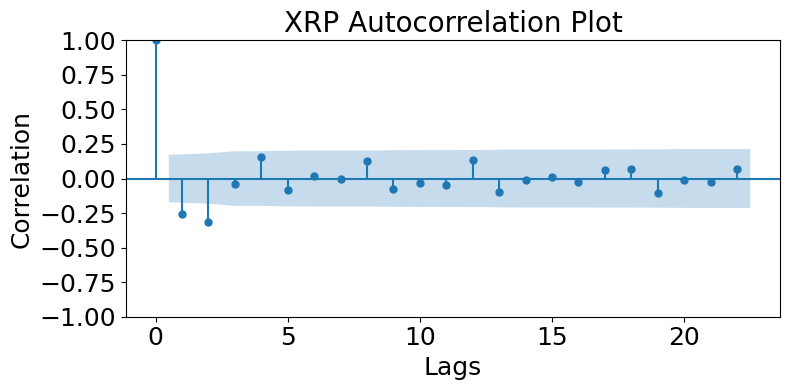

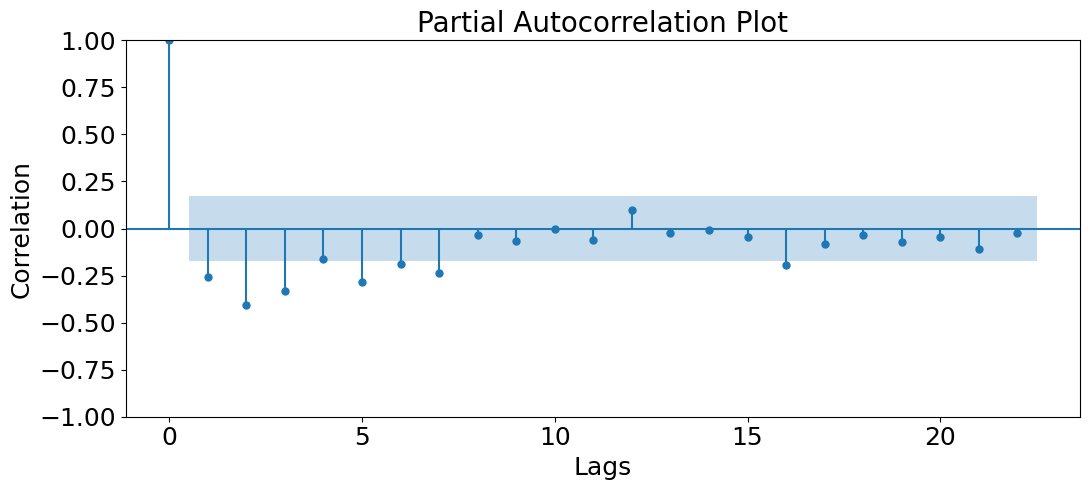

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox

def plot_xrp_autocorr():
    xrp_data = get_xrp_data()
    
    xrp_data['Close Boxcox'], lam = boxcox(xrp_data['Close'])
    xrp_data['Close Stationary'] = xrp_data['Close Boxcox'].diff().diff()
    xrp_data.dropna(inplace=True)
    
    plt.rc("figure", figsize = (8,4))
    plot_acf(xrp_data['Close Stationary'])
    plt.xlabel('Lags', fontsize = 18)
    plt.ylabel('Correlation', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title('XRP Autocorrelation Plot', fontsize = 20)
    plt.tight_layout()
    plt.show()
    
def plot_xrp_pacf():
    xrp_data = get_xrp_data()
    
    
    xrp_data['Close Boxcox'], lam = boxcox(xrp_data['Close'])
    xrp_data['Close Stationary'] = xrp_data['Close Boxcox'].diff().diff()
    xrp_data.dropna(inplace=True)
    
    plt.rc("figure", figsize=(11,5))
    plot_pacf(xrp_data['Close Stationary'], method='ywm')
    plt.xlabel('Lags', fontsize=18)
    plt.ylabel('Correlation', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title('Partial Autocorrelation Plot', fontsize=20)
    plt.tight_layout()
    plt.show()
    
plot_xrp_autocorr()
plot_xrp_pacf()

## Seasonal Decompose

To learn more from the data we can decompose it and find the trend, seasonality, and residuals. There are two ways to decompose the data, we can use the additive model where the size of the series variations are consistent on a numerical scale, or we can use the multiplicative model where the series variations are on a relative scale.

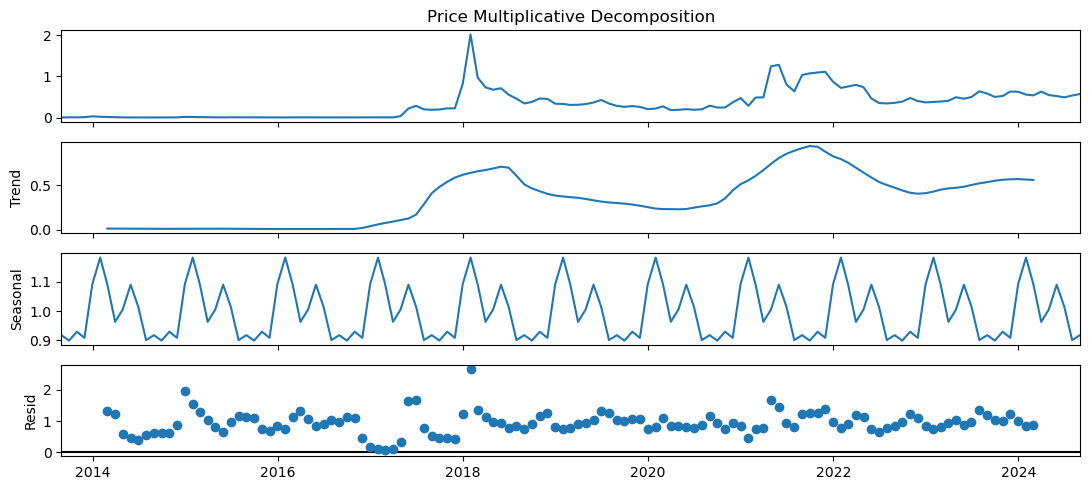

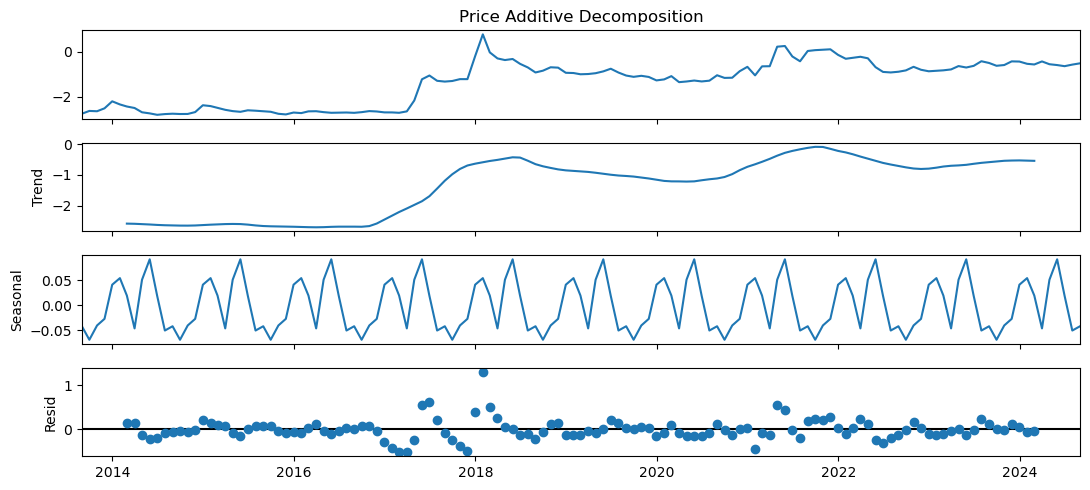

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose


#Multiplicative model
def xrp_mult_dec():
    xrp_data = get_xrp_data()
    xrp_data.rename(columns = {'Close' : 'Price Multiplicative Decomposition'}, inplace = True)
    xrp_mult_decomp_plot = seasonal_decompose(xrp_data['Price Multiplicative Decomposition'], model = "multiplicative")
    xrp_mult_decomp_plot.plot()
    plt.show()

# Additive model
def xrp_add_dec():
    xrp_data = get_xrp_data()
    xrp_data['Close Box-cox'], lam = boxcox(xrp_data['Close'])
    xrp_data.rename(columns = {'Close Box-cox' : 'Price Additive Decomposition'}, inplace = True)
    xrp_add_decomp_plot = seasonal_decompose(xrp_data['Price Additive Decomposition'], model = "additive")
    xrp_add_decomp_plot.plot()
    plt.show()
    
xrp_mult_dec()
xrp_add_dec()

## ARIMA Model

An ARIMA model consists of three order parameters:

1. p is the order of the Auto-Regressive term

2. q is the order of the Moving Average term

3. d is the number of differencing required to make the time series stationary

The value ‘p’ is the order of the ‘Auto Regressive’ (AR) term, it refers to the number of lags of Y to be used as predictors. To find out the required number of 'p' terms we can inspect the Partial Autocorrelation (PACF) plot, for our data the best value of p is 7. The value of d, is the minimum number of differencing needed to make the series stationary. The value ‘q’ is the order of the ‘Moving Average’ (MA) term, it refers to the number of lagged forecast errors that should go into the ARIMA Model. To find out the required number of 'q' terms we can inspect the Autocorrelation (ACF) plot, for our data the best value of p is 3. Since we use Boxcox to transform the closing price, once we make the forecasts, we need to transform the forecasted values using the inverse function of Boxcox.


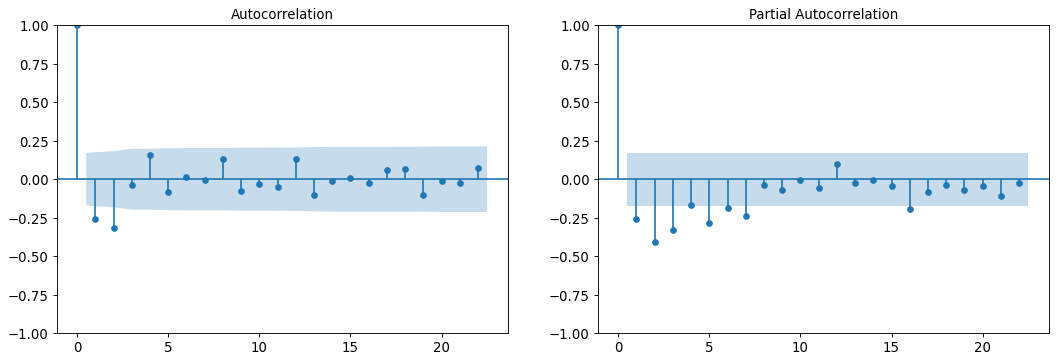

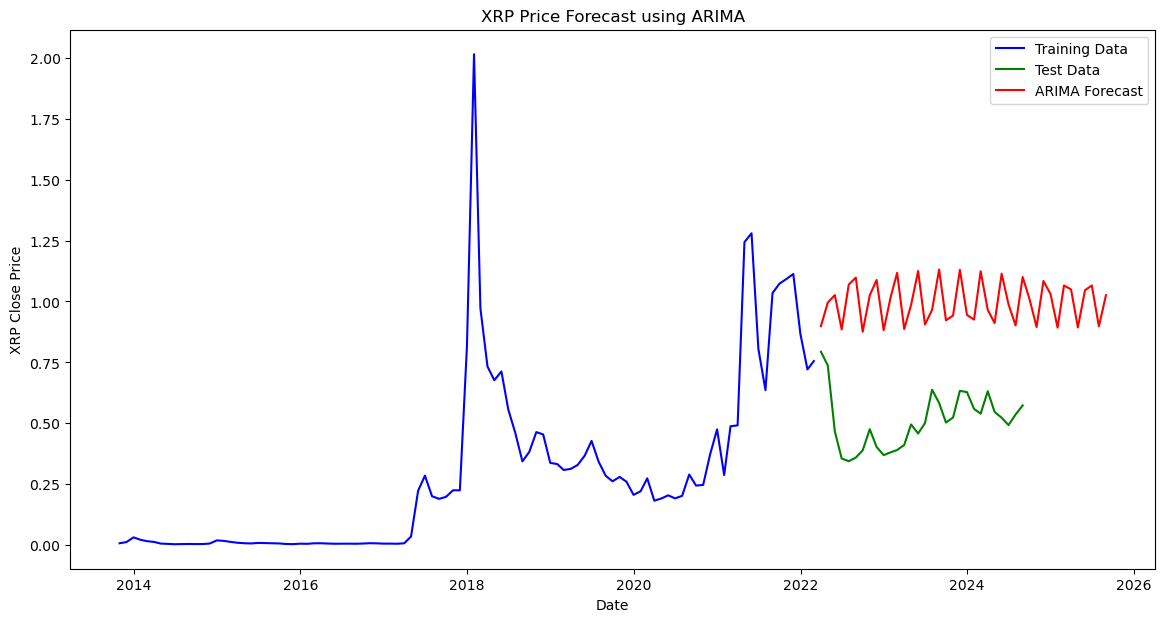

In [6]:
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

def xrp_ARIMA_model():
    xrp_data = get_xrp_data()
    
    # boxcox and difference
    xrp_data['Close Boxcox'], lam = boxcox(xrp_data['Close'])
    xrp_data['Close Stationary'] = xrp_data['Close Boxcox'].diff().diff()
    xrp_data.dropna(inplace=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    plot_acf(xrp_data['Close Stationary'], ax = ax1)
    plot_pacf(xrp_data['Close Stationary'], method='ywm', ax = ax2)
    ax1.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)
    plt.show()
    # from the plots we find p = 13 from pacf and q = 3 from acf
    
    train_set = xrp_data.iloc[:-30]
    test_set = xrp_data.iloc[-30:]
    
    #model
    ARIMA_model = ARIMA(train_set['Close Stationary'], order = (7,1,3)).fit()
    xrp_boxcox_forecasts = ARIMA_model.forecast(len(test_set)+12)
    xrp_forecasts = inv_boxcox(xrp_boxcox_forecasts,lam)
    
    # xrp_forecasts = pd.DataFrame(xrp_forecasts, index = test_set.index, columns=['ARIMA Forecasts'])

    plt.figure(figsize=(14,7))
    plt.plot(train_set['Close'], label= 'Training Data', color = 'blue')
    plt.plot(test_set['Close'], label = 'Test Data', color = 'green')
    plt.plot(xrp_forecasts, label = 'ARIMA Forecast', color = 'red') 
    plt.xlabel('Date')
    plt.ylabel('XRP Close Price')
    plt.title('XRP Price Forecast using ARIMA')
    plt.legend()
    plt.show()
    
xrp_ARIMA_model()

As we see above our model is not very accurate since it doesn't include the seasonal components. Therefore, we will create a model using SARIMA to account for the Seasonal components.

## SARIMA Model

SARIMA adds a seasonality component to each factor of the ARIMA equation to produce SARIMA(p, d, q)(P, D, Q)m. Here, (P, D, Q) are the seasonal components of (p, d, q), and m is the seasonality parameter (i.e. yearly, quarterly, monthly). In our case m = 12 because it is assumed that XRP has a yearly seasonality.

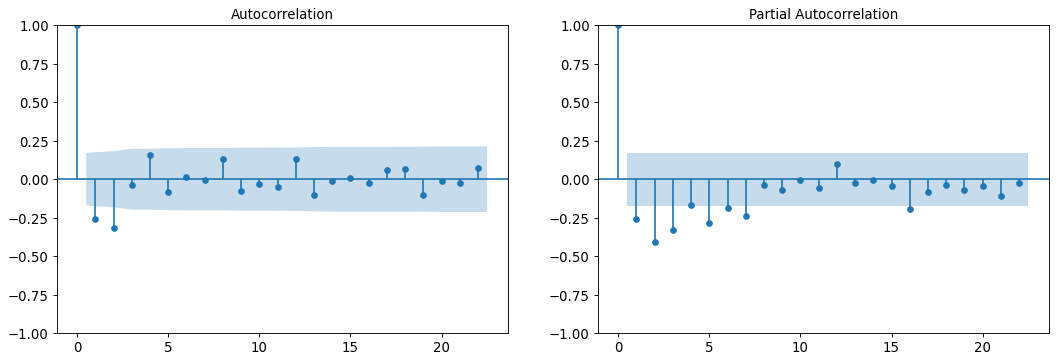

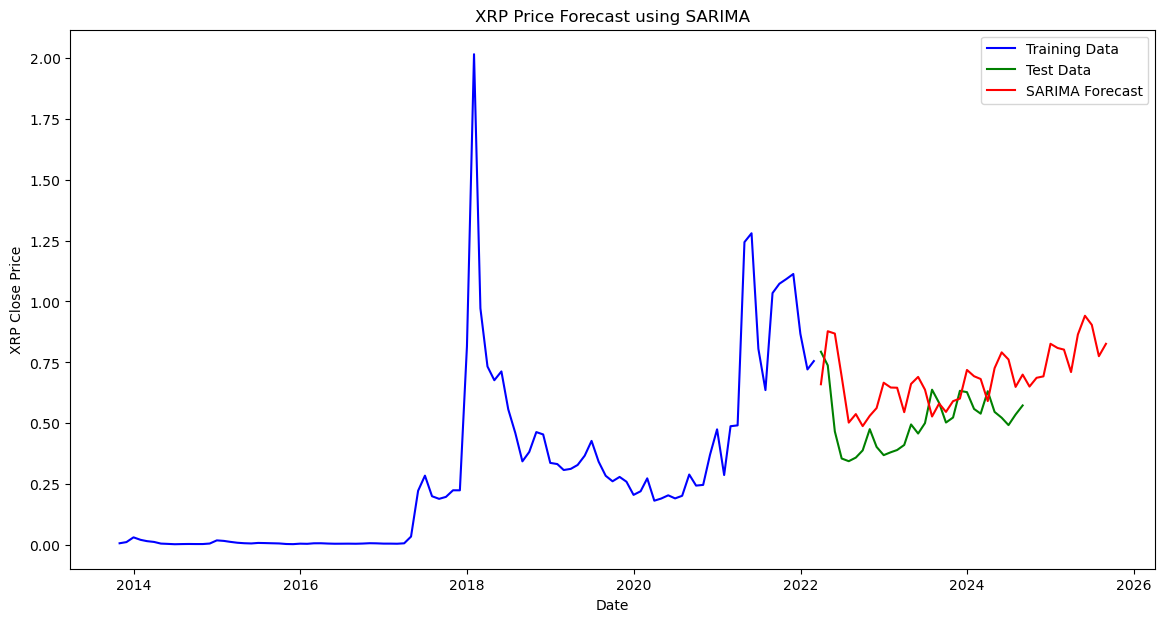

In [7]:
# SARIMA adds a seasonality component to each factor of the ARIMA equation to produce SARIMA(p, d, q)(P, D, Q)m:    
def xrp_SARIMA_model():
    xrp_data = get_xrp_data()
    
    # boxcox and difference
    xrp_data['Close Boxcox'], lam = boxcox(xrp_data['Close'])
    xrp_data['Close Stationary'] = xrp_data['Close Boxcox'].diff().diff()
    xrp_data.dropna(inplace=True)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    plot_acf(xrp_data['Close Stationary'], ax = ax1)
    plot_pacf(xrp_data['Close Stationary'], method='ywm', ax = ax2)
    ax1.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)
    plt.show()
  
    train_set = xrp_data.iloc[:-30]
    test_set = xrp_data.iloc[-30:]
    
    #model
    ARIMA_model = ARIMA(train_set['Close Boxcox'], order = (7,1,3),seasonal_order=(1,1,1,12)).fit()
    xrp_boxcox_forecasts = ARIMA_model.forecast(len(test_set)+12)
    xrp_forecasts = inv_boxcox(xrp_boxcox_forecasts,lam)
    
    plt.figure(figsize=(14,7))
    plt.plot(train_set['Close'], label= 'Training Data', color = 'blue')
    plt.plot(test_set['Close'], label = 'Test Data', color = 'green')
    plt.plot(xrp_forecasts, label = 'SARIMA Forecast', color = 'red') 
    plt.xlabel('Date')
    plt.ylabel('XRP Close Price')
    plt.title('XRP Price Forecast using SARIMA')
    plt.legend()
    plt.show()
    
xrp_SARIMA_model()